In [1]:
# !pip install qiskit
# !pip install qiskit_optimization
# !pip install qiskit_machine_learning
# !pip install pylatexenc
# !pip install qiskit_ibm_runtime
# !pip install qiskit-aer

In [2]:
# !pip install matplotlib

In [3]:
# !pip install qiskit_algorithms

In [4]:
import numpy as np
import tensorflow as tf


# Get the MNIST Data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

2024-05-06 19:20:14.900237: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 19:20:14.903357: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 19:20:14.939247: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 19:20:15.798056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
n_qubits = 2  # Number of qubits

latent_dim = 2 ** n_qubits    # Selected latent dimensions

reduced_classes = [0,1] # Selected (and sorted) classes

# Number of reduced classes
reduced_num_classes = len(reduced_classes)

In [6]:
def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    y_ = np.where(y == 0, -1, 1)
    return x,y_,y

In [7]:
num_classes_q = reduced_num_classes

X_ends_pre, Y_ends_pre, y_temp = filter_01(x_train, y_train)
X_tests_pre, Y_tests_pre, y_temp = filter_01(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 60000
Number of filtered test examples: 10000


In [8]:
# # All indexes
# train_index_f = (y_train == -1)
# tests_index_f = (y_test  == -1)

# # Filter indexes
# for n_class in reduced_classes:
#   train_index_f   |= (y_train == n_class)
#   tests_index_f   |= (y_test == n_class)

# num_classes_q = reduced_num_classes

# # New databases
# X_ends_pre = x_train[train_index_f]
# Y_ends_pre = y_train[train_index_f]

# X_tests_pre = x_test[tests_index_f]
# Y_tests_pre = y_test[tests_index_f]


# for i, k in enumerate(reduced_classes):
#     if i==0:
#         Y_ends_pre[Y_ends_pre == k] = -1
#         Y_tests_pre[Y_tests_pre == k] = -1
#     else:
#         Y_ends_pre[Y_ends_pre == k] = 1
#         Y_tests_pre[Y_tests_pre == k] = 1

In [9]:
Y_ends_pre

array([-1,  1,  1, ...,  1, -1,  1])

In [10]:
X_ends_pre.shape[1]

28

In [11]:
X_ends_pre1 = X_ends_pre.reshape(X_ends_pre.shape[0], X_ends_pre.shape[1]*X_ends_pre.shape[2])
X_tests_pre1 = X_tests_pre.reshape(X_tests_pre.shape[0], X_tests_pre.shape[1]*X_tests_pre.shape[2])
print(X_ends_pre1.shape)
print(X_tests_pre1.shape)

(12665, 784)
(2115, 784)


In [12]:
X_ends_pre1 = X_ends_pre1.astype('float32')
X_tests_pre1 = X_tests_pre1.astype('float32')

In [13]:
# initializing the pca
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=latent_dim)
pca.fit(X_ends_pre1)

print(f'Total number of components used after PCA : {pca.n_components_}')

Total number of components used after PCA : 4


In [15]:
train_img = pca.transform(X_ends_pre1)
test_img = pca.transform(X_tests_pre1)

print(f'train_img shape : {train_img.shape}')
print(f'test_img shape : {test_img.shape}')

train_img shape : (12665, 4)
test_img shape : (2115, 4)


In [16]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = 'lbfgs')
clf.fit(train_img, Y_ends_pre)

MLPClassifier(solver='lbfgs')

In [17]:
print('Training score : ', clf.score(train_img, Y_ends_pre))
print('Testing score  : ', clf.score(test_img, Y_tests_pre))

Training score :  1.0
Testing score  :  0.9976359338061466


In [18]:
# class Autoencoder(tf.keras.models.Model):
#   def __init__(self, latent_dim):
#     super(Autoencoder, self).__init__()
#     self.latent_dim = latent_dim
#     self.encoder = tf.keras.Sequential([
#       tf.keras.layers.Flatten(name = "faltten_1"),
#       tf.keras.layers.Dense(196, activation='relu', name = "dense_1"),
#       tf.keras.layers.Dense(64, activation='relu', name = "dense_2"),
#       tf.keras.layers.Dense(32, activation='relu', name = "dense_3"),
#       tf.keras.layers.Dense(latent_dim, activation='sigmoid', name = "dense_3.2"),
#     ])
#     self.decoder = tf.keras.Sequential([
#       tf.keras.layers.Dense(32, activation='relu', name = "dense_4.0"),
#       tf.keras.layers.Dense(64, activation='relu', name = "dense_4"),
#       tf.keras.layers.Dense(196, activation='relu', name = "dense_5"),
#       tf.keras.layers.Dense(784, activation='relu', name = "dense_6"),
#       tf.keras.layers.Reshape((28, 28), name = "reshape_1")
#     ])

#   def call(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

# # Prepare and compile the model
# autoencoder = Autoencoder(latent_dim)
# autoencoder.compile(optimizer='adam', loss='mse', metrics=["accuracy"])

# # Train the model with the filtered data
# autoencoder.fit(X_ends_pre, X_ends_pre, epochs=50, shuffle=True, validation_data=(X_tests_pre, X_tests_pre))

In [19]:
# # Encode data with our new autoencoder
# QX_train = autoencoder.encoder(X_ends_pre).numpy()
# QX_test = autoencoder.encoder(X_tests_pre).numpy()

In [20]:
# Encode data with our new autoencoder
QX_train = train_img
QX_test = test_img

**QCNN**

In [21]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import qiskit
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import *
from qiskit import QuantumCircuit, transpile, assemble, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, Parameter
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, SPSA, NFT
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import GroverOperator, Diagonal
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke, FakeAuckland, FakeWashington, FakeLagosV2, FakeMumbaiV2
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import time

from qiskit.providers.fake_provider import GenericBackendV2

algorithm_globals.random_seed = 12345

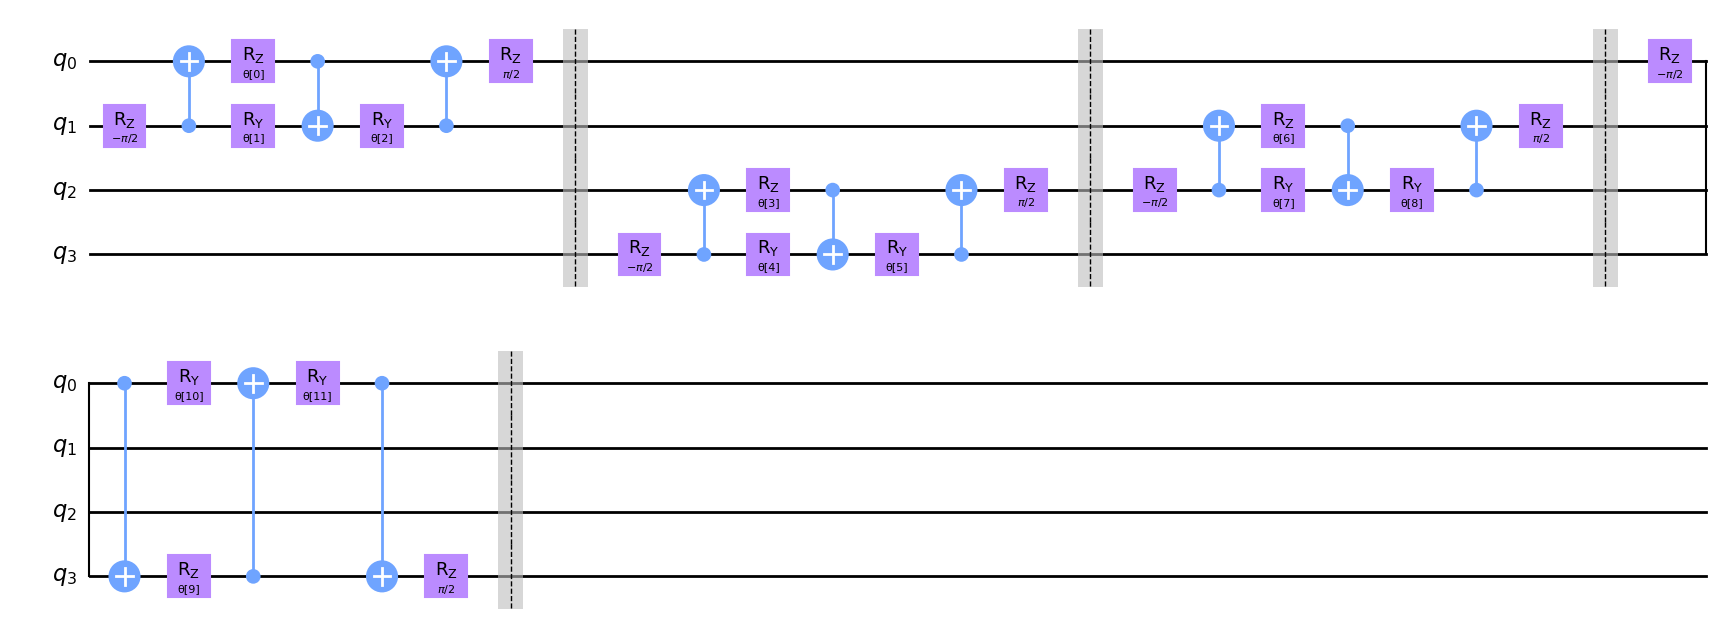

In [22]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

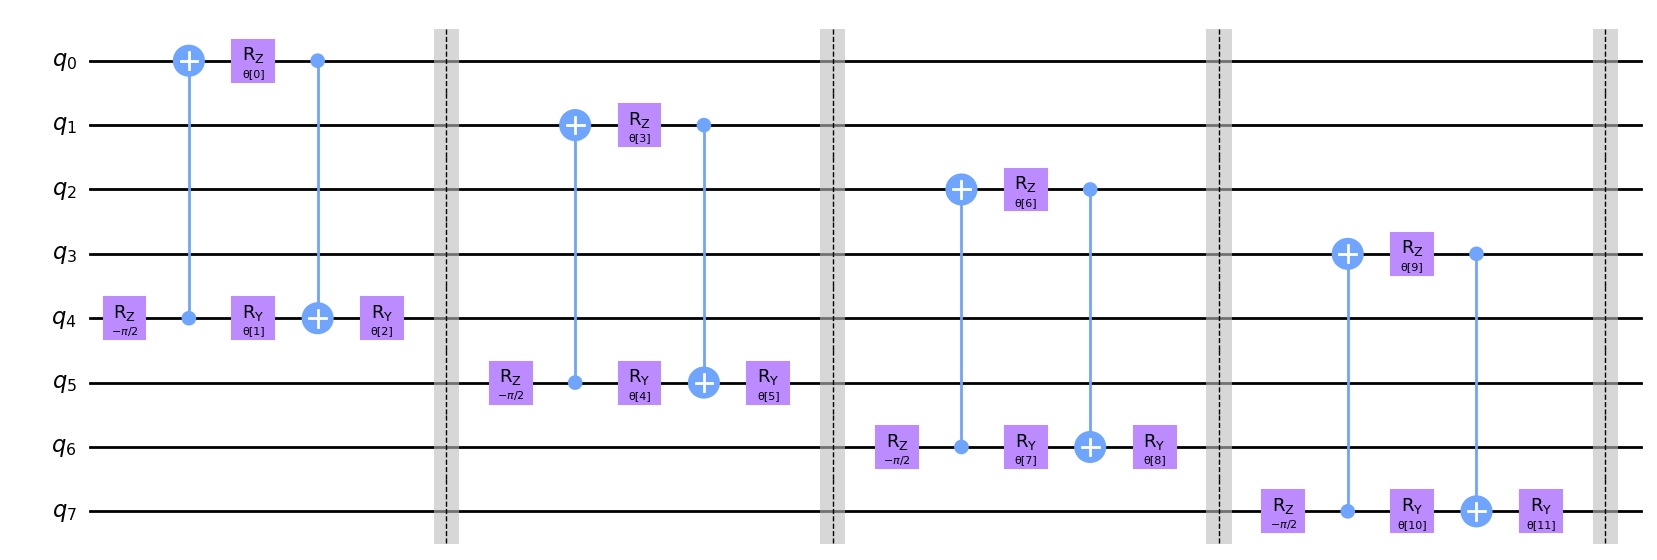

In [23]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1, 2, 3]
sinks = [4, 5, 6, 7]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [24]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [25]:
latent_dim

4

In [26]:
# feature_map = ZFeatureMap(4)

# ansatz = QuantumCircuit(4, name="Ansatz")

# # Third Convolutional Layer
# ansatz.compose(conv_layer(4, "c3"), list(range(4)), inplace=True)

# # Third Pooling Layer
# ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(4)), inplace=True)

# # Fourth Convolutional Layer
# ansatz.compose(conv_layer(2, "c4"), list(range(2, 4)), inplace=True)

# # Fouth Pooling Layer
# ansatz.compose(pool_layer([0], [1], "p4"), list(range(2, 4)), inplace=True)

# # Combining the feature map and ansatz
# circuit = QuantumCircuit(4)
# circuit.compose(feature_map, range(4), inplace=True)
# circuit.compose(ansatz, range(4), inplace=True)

In [27]:
feature_map = ZFeatureMap(latent_dim)

ansatz = QuantumCircuit(latent_dim, name="Ansatz")

for p,i in enumerate(range(latent_dim, 0, -2)):
  ansatz.compose(conv_layer(i, "c"+str(p)), list(range(p*2,latent_dim)), inplace=True)
  ansatz.compose(pool_layer([k for k in range(int(i/2))], [k for k in range(int(i/2),i)],
                            "p"+str(p)), list(range(p*2,latent_dim)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(latent_dim)
circuit.compose(feature_map, range(latent_dim), inplace=True)
circuit.compose(ansatz, range(latent_dim), inplace=True)

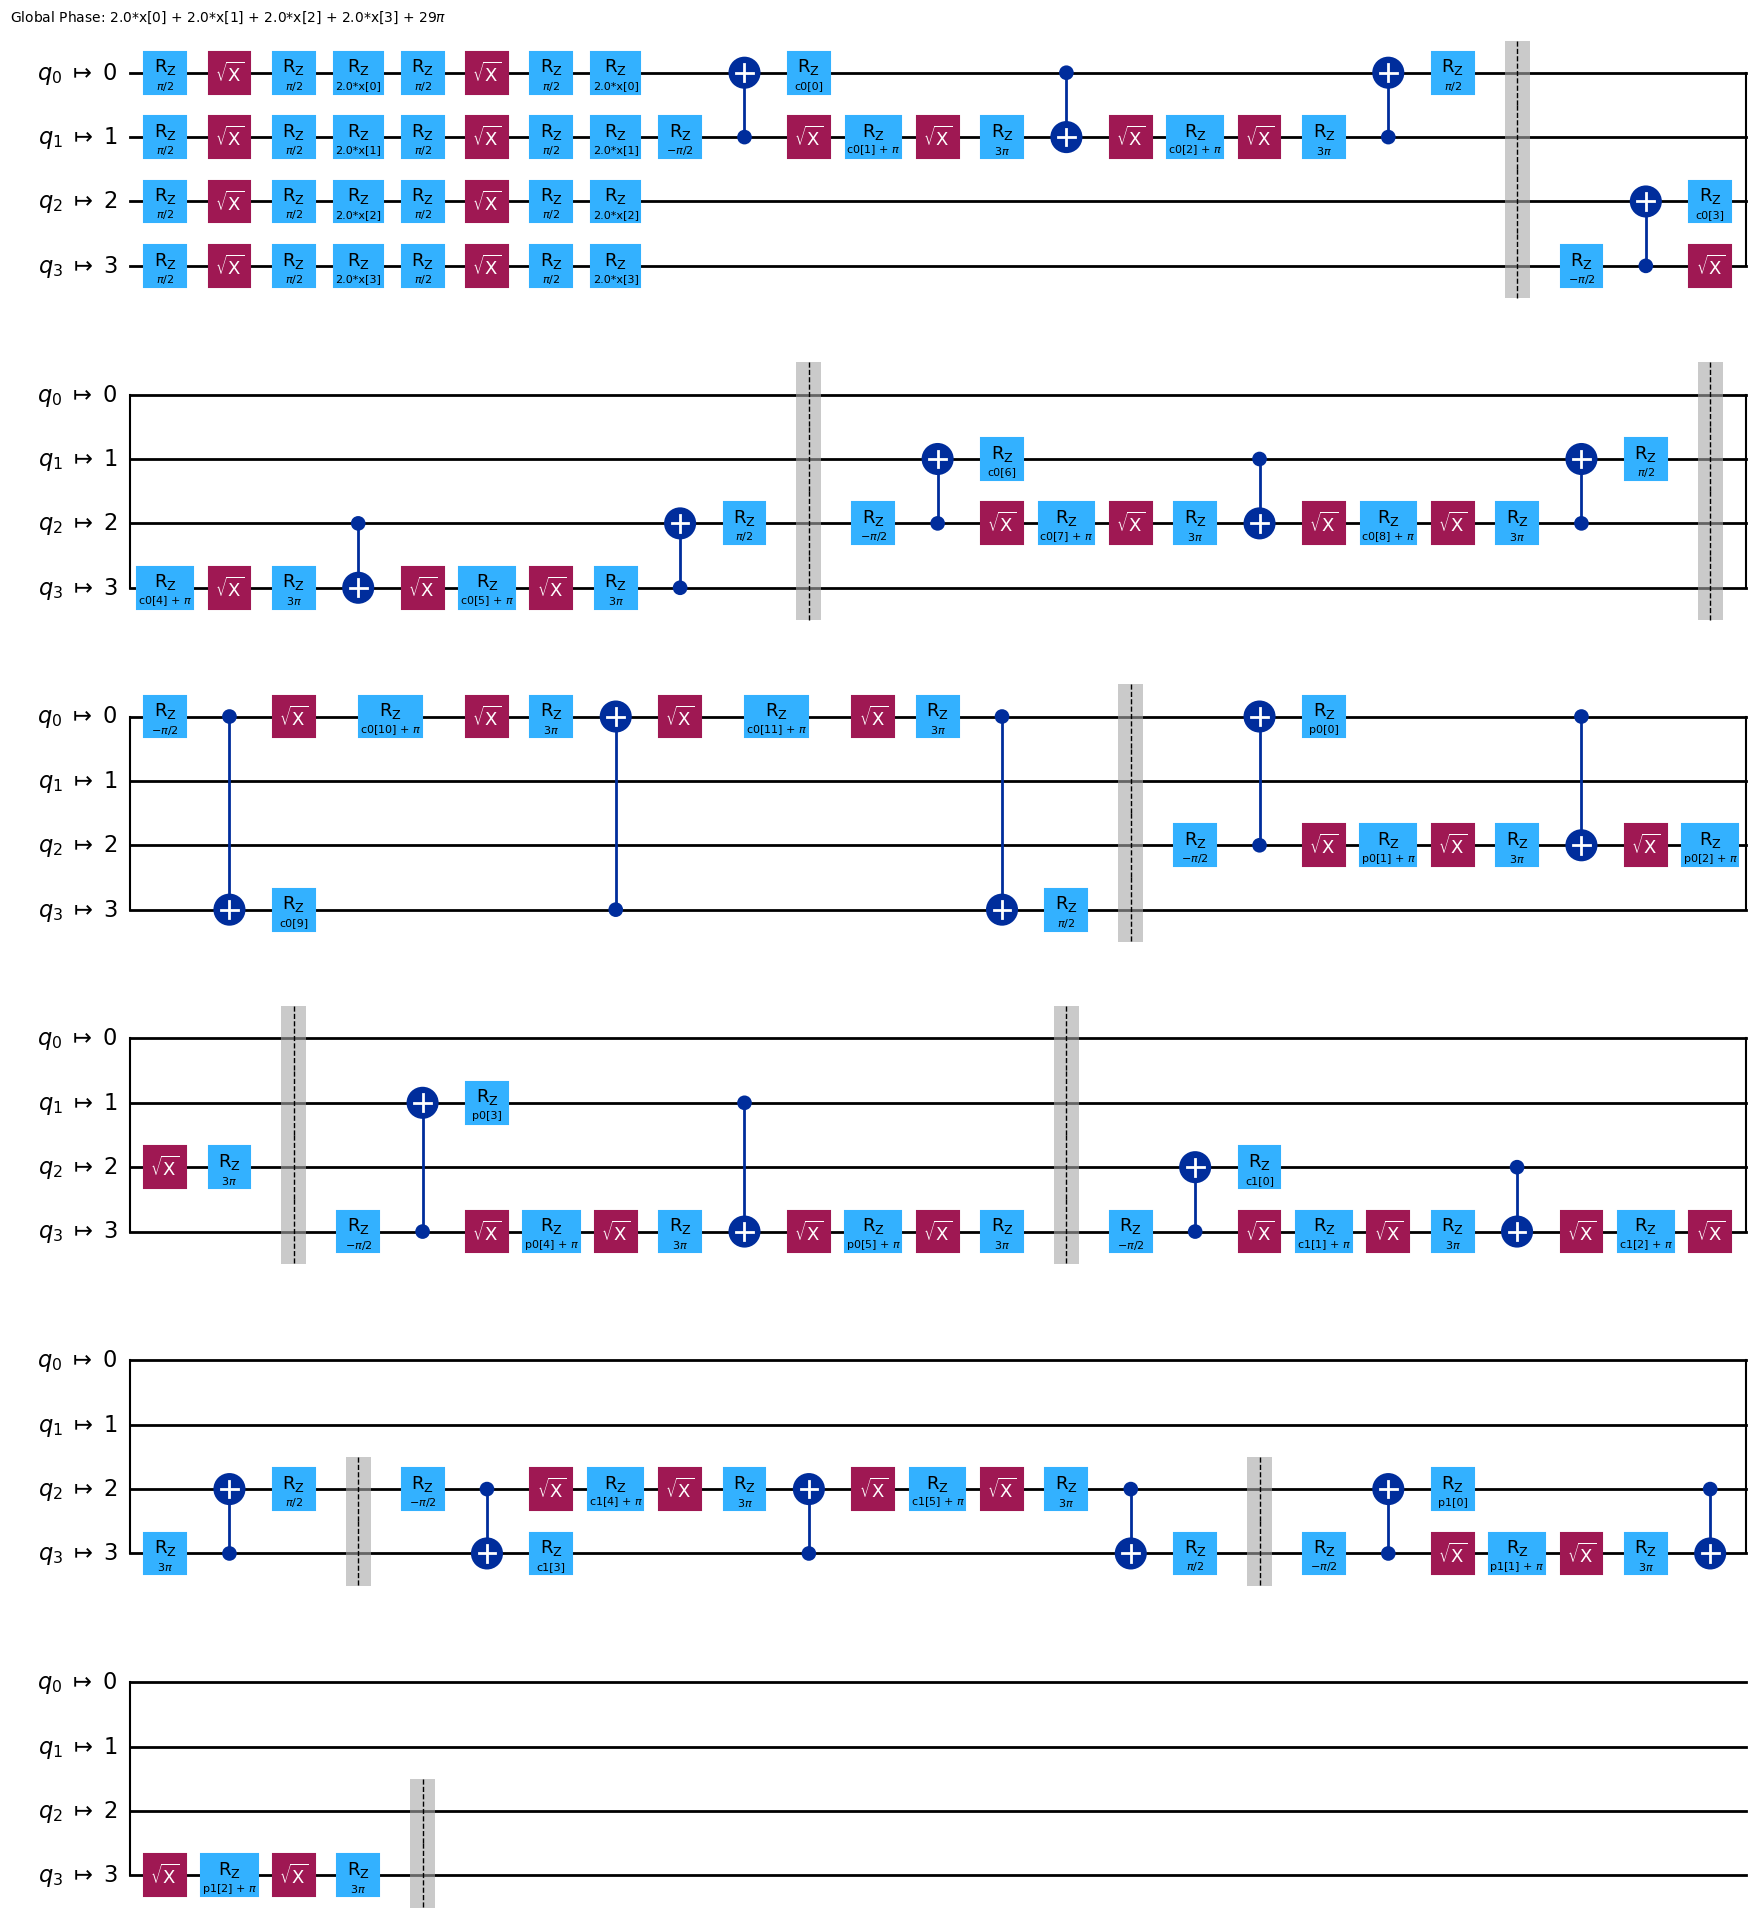

In [28]:
backend = GenericBackendV2(num_qubits=latent_dim)

# Transpile the circuit
pass_manager = generate_preset_pass_manager(
    optimization_level=1,
    backend=backend,
    layout_method="trivial", # Fixed layout mapped in circuit order
)

transpiled_circ1 = pass_manager.run(circuit)

# View the transpiled circuit
transpiled_circ1.draw(output='mpl', idle_wires=False)

In [29]:
#observable = SparsePauliOp.from_list([("Z" + "I" * 63, 1)])
observable = SparsePauliOp.from_list([("Z" * circuit.num_qubits, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=transpiled_circ1,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
#with open("11_qcnn_initial_point.json", "r") as f:
#    initial_point = json.load(f)

In [30]:

classifier7 = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,# Set max iterations here

)

In [28]:
# n_sample = 3000
# x = np.asarray(QX_train)[:n_sample]
# y = np.asarray(Y_ends_pre)[:n_sample]

In [31]:
x = np.asarray(QX_train)
y = np.asarray(Y_ends_pre)

In [32]:
x_test = np.asarray(QX_test)
y_test = np.asarray(Y_tests_pre)

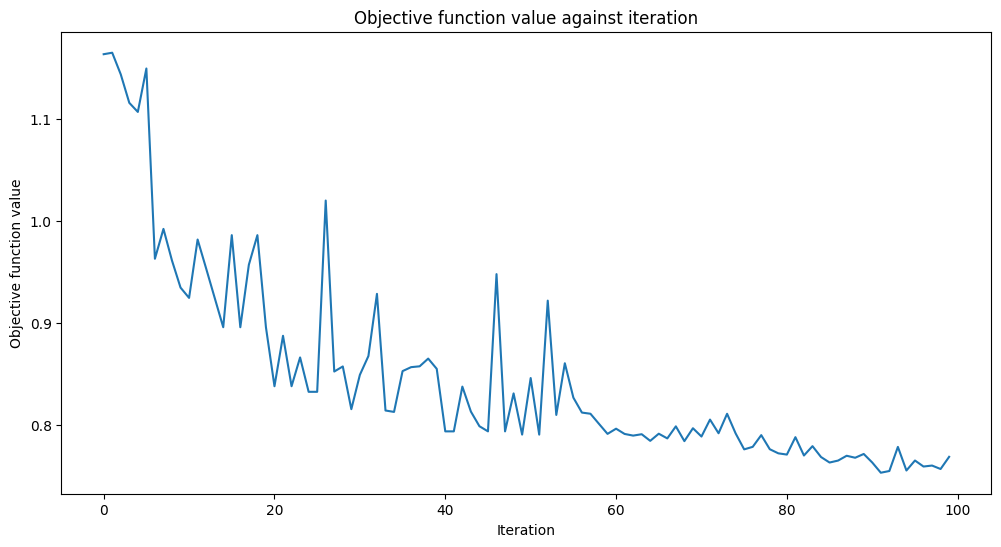

Accuracy from the train data 7 : 72.67%


In [33]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier7.fit(x, y)

# score classifier
print(f"Accuracy from the train data 7 : {np.round(100 * classifier7.score(x, y), 2)}%")

In [34]:
y_predict7 = classifier7.predict(x_test)
print(f"Accuracy from the test data 7 : {np.round(100 * classifier7.score(x_test, y_test), 2)}%")

Accuracy from the test data 7 : 74.0%


In [35]:
print("Precision: ", precision_score(y_test, y_predict7, average='weighted').round(3))

print("Recall (sensitivity): ", recall_score(y_test, y_predict7, average='weighted').round(3))

print("F1 score: ", f1_score(y_test, y_predict7, average='weighted').round(3))

Precision:  0.788
Recall (sensitivity):  0.74
F1 score:  0.723


In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predict7)

array([[ 479,  501],
       [  49, 1086]])

**ZZ Feature Map**

In [37]:
feature_map = ZZFeatureMap(latent_dim)

ansatz = QuantumCircuit(latent_dim, name="Ansatz")

for p,i in enumerate(range(latent_dim, 0, -2)):
  ansatz.compose(conv_layer(i, "c"+str(p)), list(range(p*2,latent_dim)), inplace=True)
  ansatz.compose(pool_layer([k for k in range(int(i/2))], [k for k in range(int(i/2),i)],
                            "p"+str(p)), list(range(p*2,latent_dim)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(latent_dim)
circuit.compose(feature_map, range(latent_dim), inplace=True)
circuit.compose(ansatz, range(latent_dim), inplace=True)

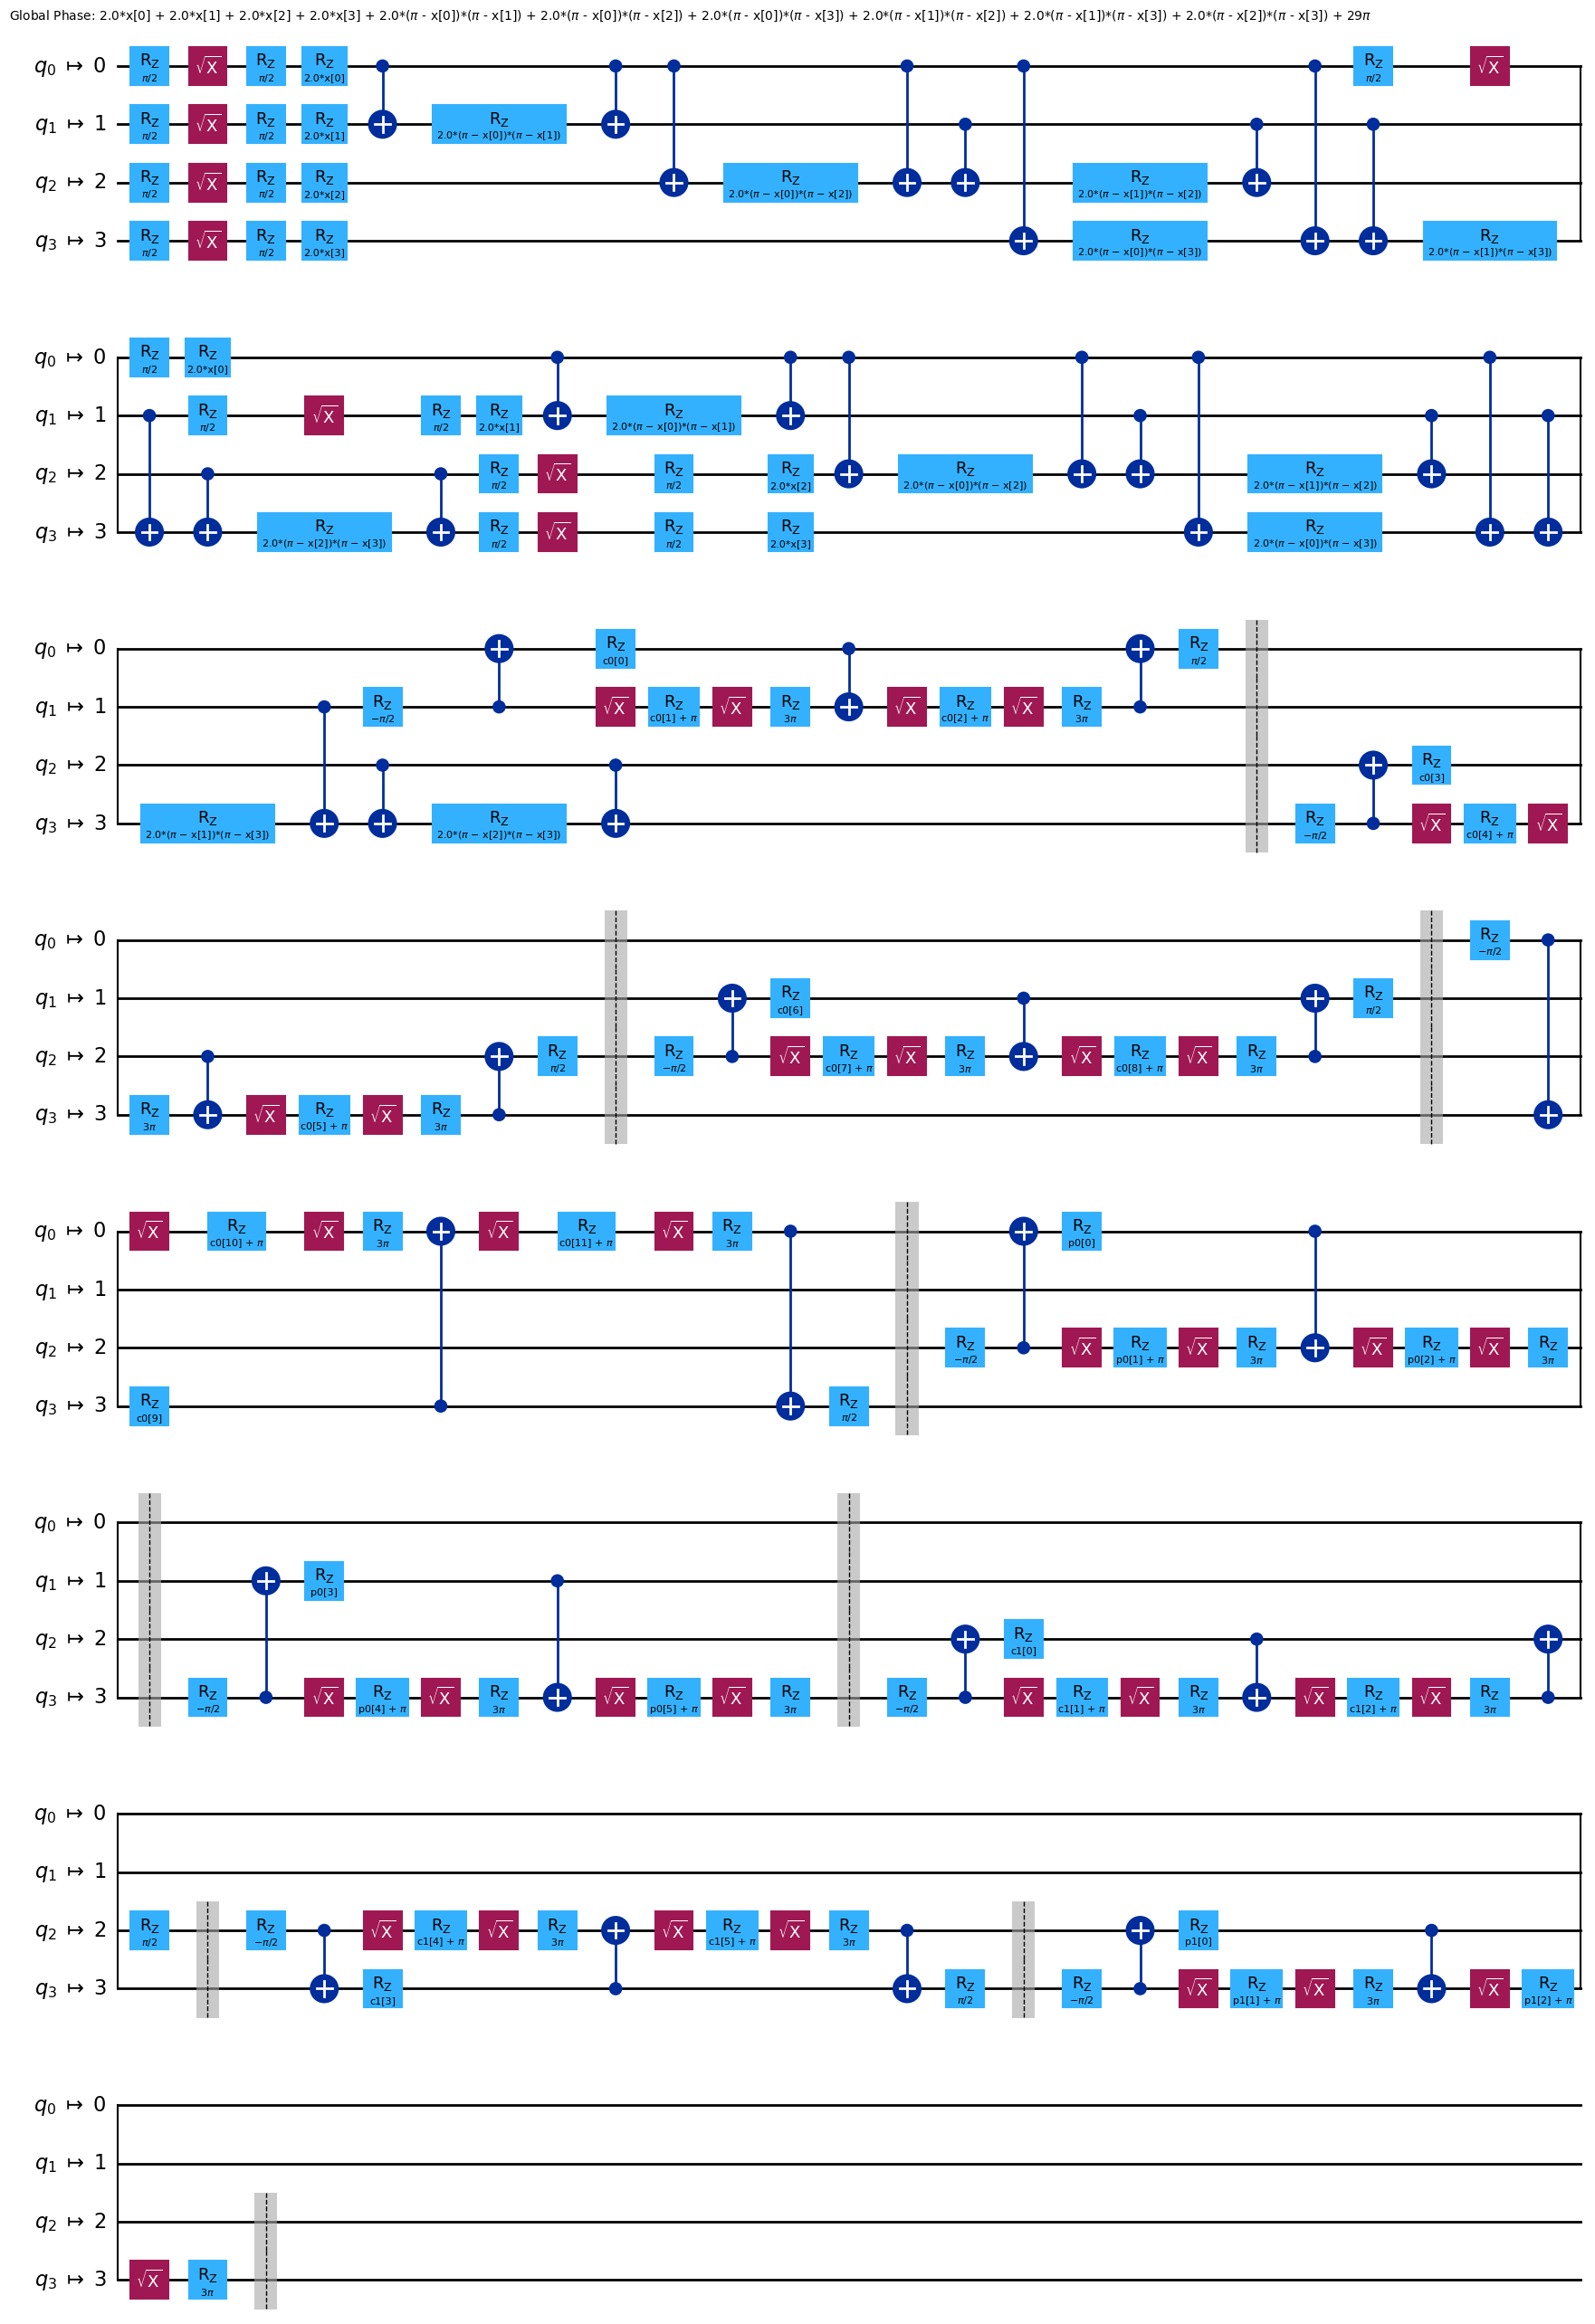

In [38]:
backend = GenericBackendV2(num_qubits=latent_dim)

# Transpile the circuit
pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    layout_method="trivial", # Fixed layout mapped in circuit order
)

#pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_circ11 = pass_manager.run(circuit)
#transpiled_circ1.barrier()
#transpiled_circ1.measure_all()
# View the transpiled circuit
transpiled_circ11.draw(output='mpl', idle_wires=False)

In [39]:
#observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])
observable = SparsePauliOp.from_list([("Z" * circuit.num_qubits, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn11 = EstimatorQNN(
    circuit=transpiled_circ11,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
#with open("11_qcnn_initial_point.json", "r") as f:
#    initial_point = json.load(f)

In [40]:
classifier11 = NeuralNetworkClassifier(
    qnn11,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,# Set max iterations here

)

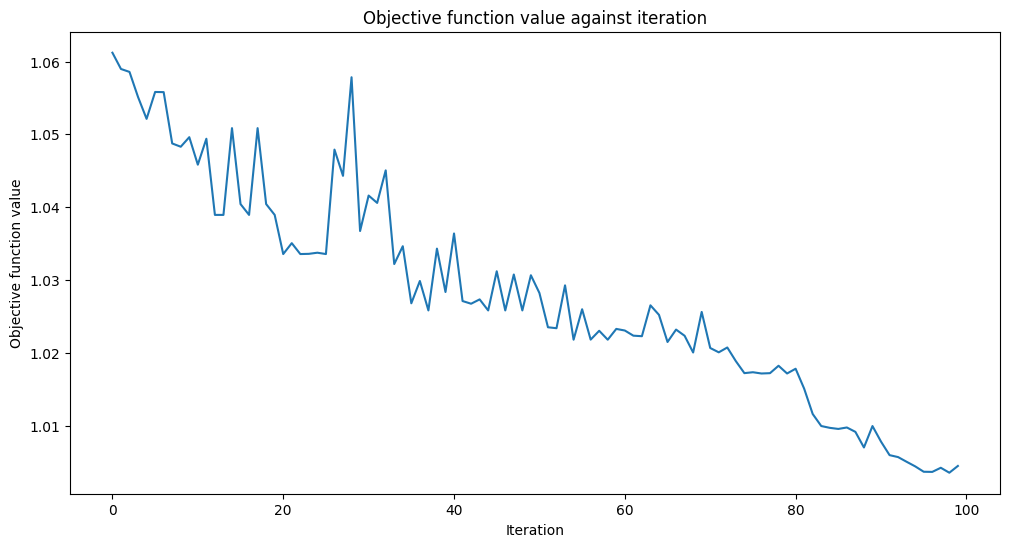

Accuracy from the train data 6 : 54.39%
8928.615050554276


In [41]:
start = time.time()
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier11.fit(x, y)

# score classifier
print(f"Accuracy from the train data 6 : {np.round(100 * classifier11.score(x, y), 2)}%")
end = time.time()
print(end - start)
end = 0
start = 0

In [42]:
y_predict11 = classifier11.predict(x_test)

print(f"Accuracy from the test data 4 : {np.round(100 * classifier11.score(x_test, y_test), 2)}%")

Accuracy from the test data 4 : 55.32%


In [43]:
print("Precision: ", precision_score(y_test, y_predict11, average='weighted').round(3))

print("Recall (sensitivity): ", recall_score(y_test, y_predict11, average='weighted').round(3))

print("F1 score: ", f1_score(y_test, y_predict11, average='weighted').round(3))

Precision:  0.554
Recall (sensitivity):  0.553
F1 score:  0.554


In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predict11)

array([[525, 455],
       [490, 645]])